In [1]:
import os
import math
import time
import datetime
import itertools
import numpy as np 
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

from operator import itemgetter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [3]:
df = pd.read_csv("../data/BrentOilPrices.csv")
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


## Preprocessing

#### 1) Need to convert Date column to standard format

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])
df.head()

C:\Users\getac\AppData\Local\Temp\ipykernel_22216\2259756741.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## EDA

#### Visualizing Full Data as a line plot

Text(0.5, 1.0, 'Brent Oil Price Trend')

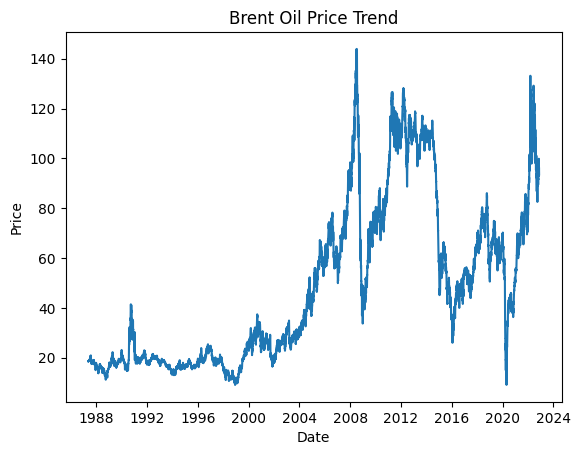

In [5]:
g = sns.lineplot(x='Date',y='Price',data = df)
plt.title("Brent Oil Price Trend")

#### Function to plot Oil Price Trend between specific p

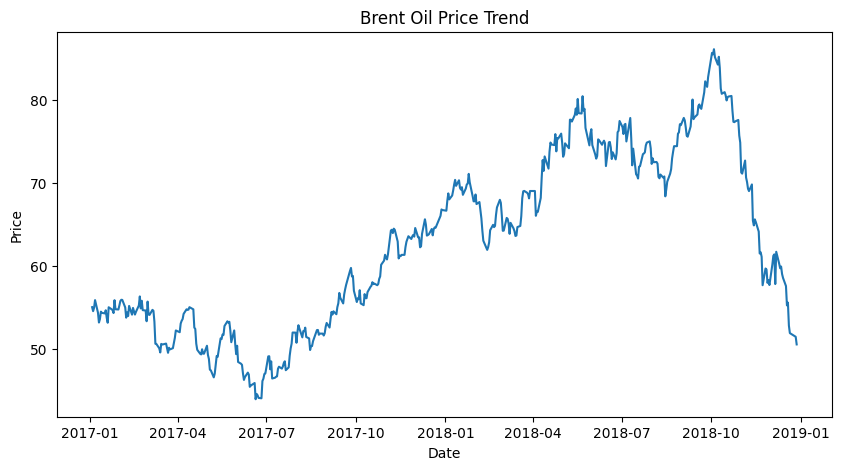

In [6]:
def plot_price_trend(df, start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the line plot of the data using seaborn.
    
    The dataframe may not be indexed on any Datetime column.
    In this case, we use mask to filter out the date.
    
    PS - There is another function provided later in the notebook 
    which used indexed column to filter data
    """
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    sdf = df.loc[mask]
    plt.figure(figsize = (10,5))
    chart = sns.lineplot(x='Date',y='Price',data = sdf)
#     chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("Brent Oil Price Trend")
plot_price_trend(df,'2017-01-01','2019-01-01')



## Forecast Model

### 1) Using Prophet

In [7]:
from prophet import Prophet
m = Prophet()

pro_df = df
pro_df.columns = ['ds','y']
pro_df.head()

C:\Users\getac\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [8]:
m.fit(pro_df)
future = m.make_future_dataframe(periods = 90)
forecast = m.predict(future)


05:06:23 - cmdstanpy - INFO - Chain [1] start processing
05:06:28 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,15.841985,3.573130,30.052706,15.841985,15.841985,0.923168,0.923168,0.923168,-0.547698,-0.547698,-0.547698,1.470866,1.470866,1.470866,0.0,0.0,0.0,16.765154
1,1987-05-21,15.846501,3.622354,30.914006,15.846501,15.846501,1.071425,1.071425,1.071425,-0.432347,-0.432347,-0.432347,1.503772,1.503772,1.503772,0.0,0.0,0.0,16.917926
2,1987-05-22,15.851017,2.538857,30.218558,15.851017,15.851017,1.057041,1.057041,1.057041,-0.474912,-0.474912,-0.474912,1.531953,1.531953,1.531953,0.0,0.0,0.0,16.908058
3,1987-05-25,15.864564,3.221793,30.760460,15.864564,15.864564,1.122984,1.122984,1.122984,-0.465584,-0.465584,-0.465584,1.588567,1.588567,1.588567,0.0,0.0,0.0,16.987548
4,1987-05-26,15.869080,2.770363,31.745673,15.869080,15.869080,1.022884,1.022884,1.022884,-0.575771,-0.575771,-0.575771,1.598655,1.598655,1.598655,0.0,0.0,0.0,16.891964


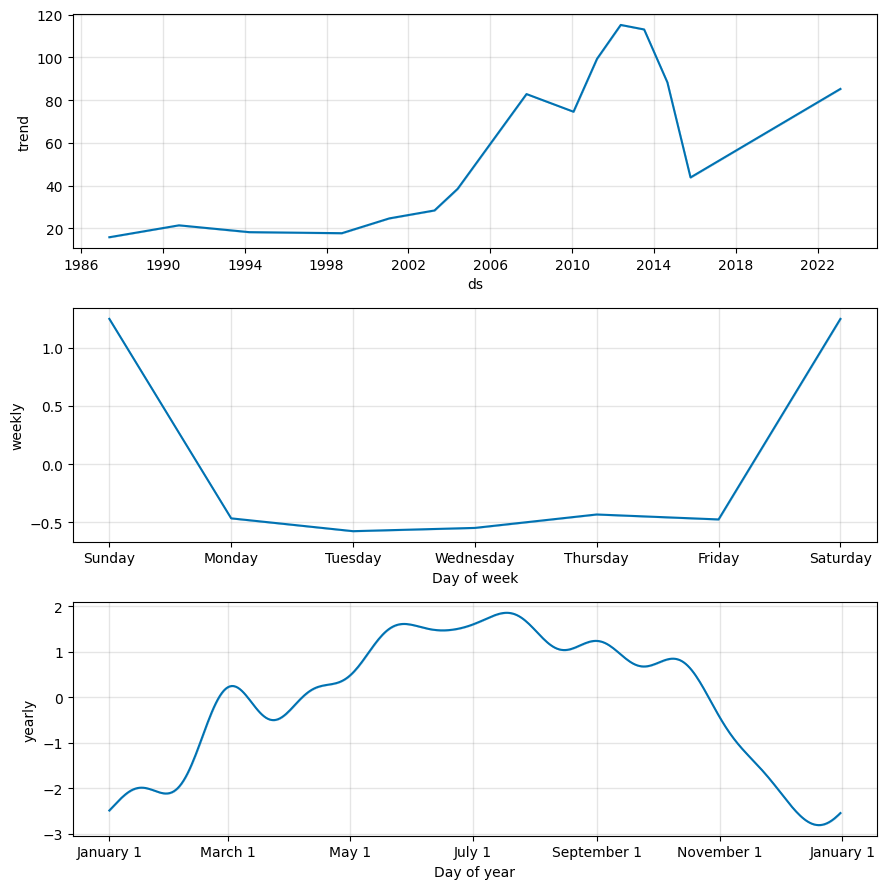

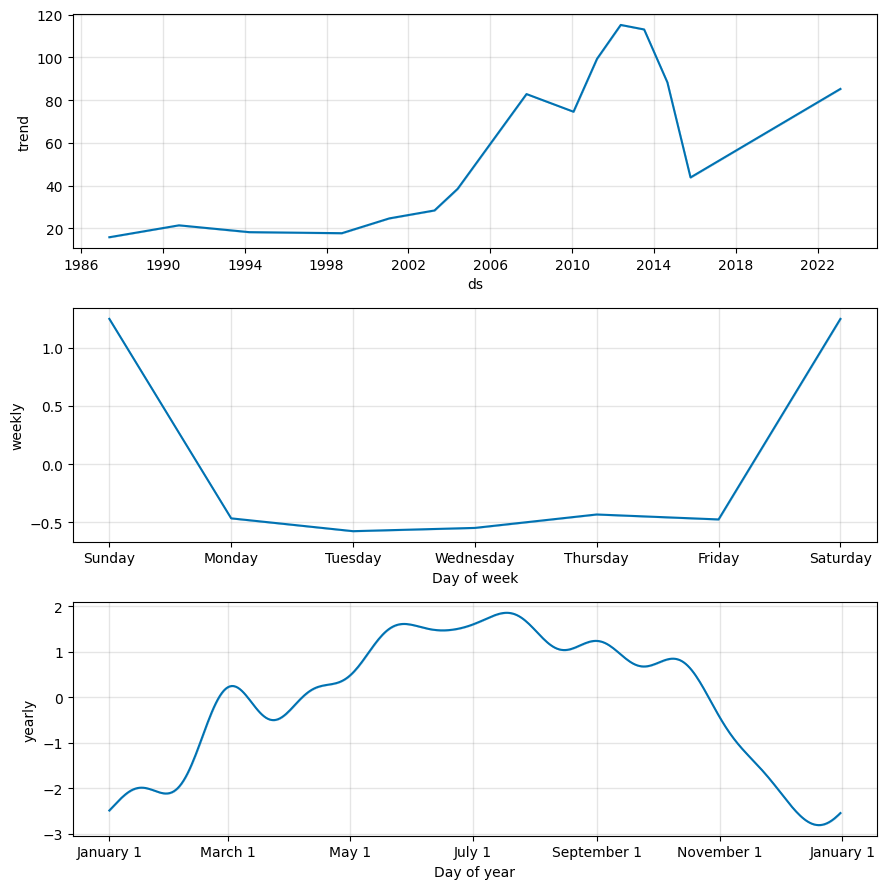

In [10]:
m.plot_components(forecast)

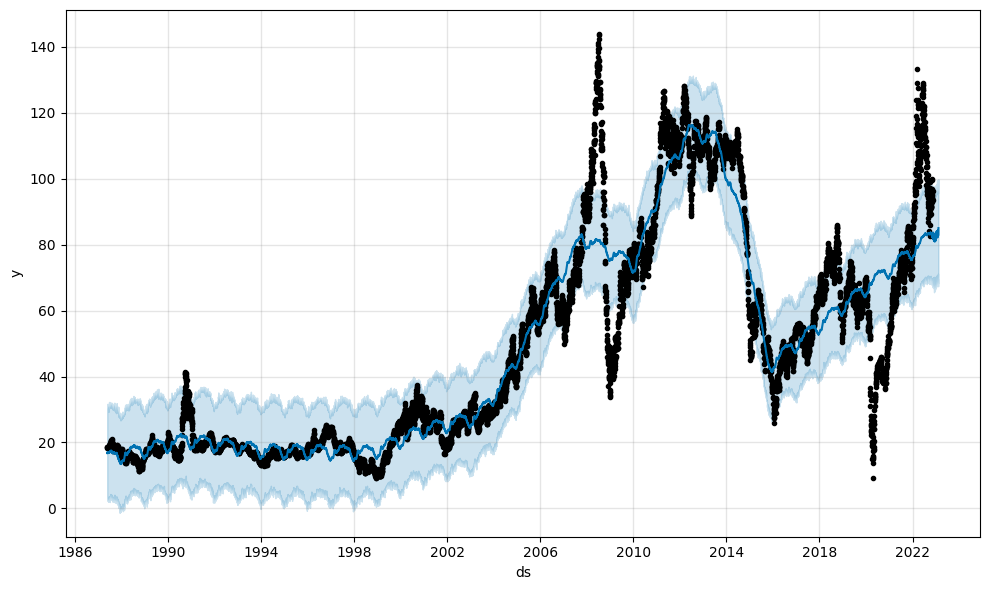

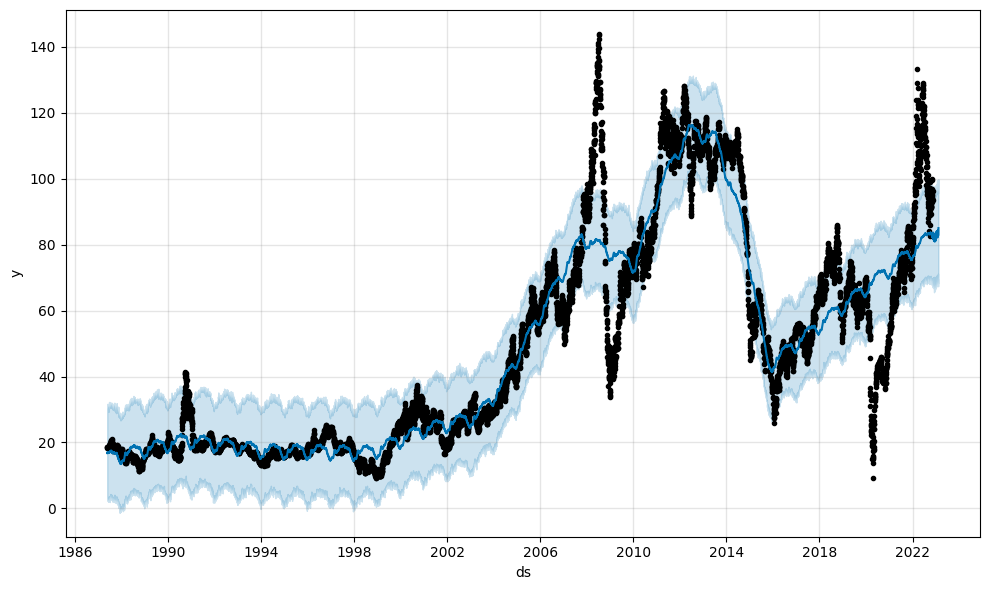

In [11]:
m.plot(forecast)

In [12]:
# Visualize side by side the original data and the forecast data. So for this, we join the original and forecast data on the column 'ds'

cmp_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(pro_df.set_index('ds'))
cmp_df.head()


,yhat,yhat_lower,yhat_upper,y
ds,,,,
1987-05-20,16.765154,3.573130,30.052706,18.63
1987-05-21,16.917926,3.622354,30.914006,18.45
1987-05-22,16.908058,2.538857,30.218558,18.55
1987-05-25,16.987548,3.221793,30.760460,18.60
1987-05-26,16.891964,2.770363,31.745673,18.63


C:\Users\getac\AppData\Local\Temp\ipykernel_22216\3521066243.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


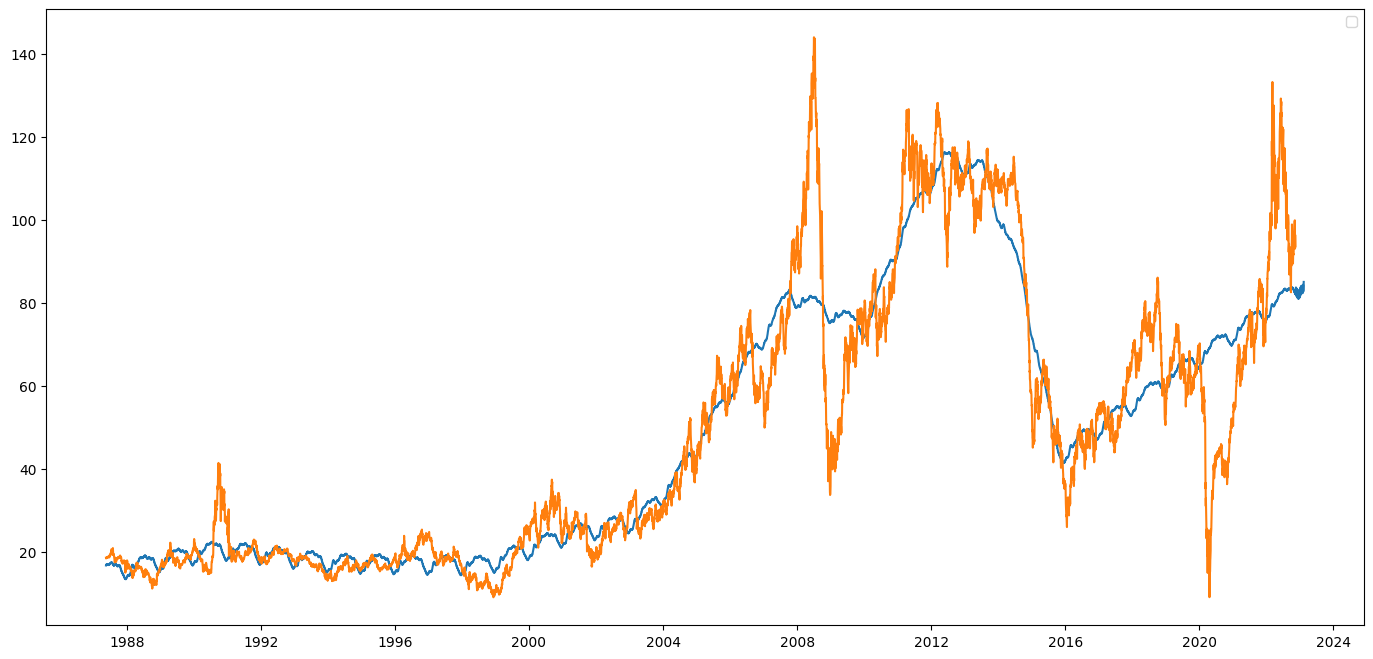

In [13]:
##Visualize the original and forecast data alongside each other
plt.figure(figsize=(17,8))
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['y'])
plt.legend()
plt.show()




C:\Users\getac\AppData\Local\Temp\ipykernel_22216\2962285042.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


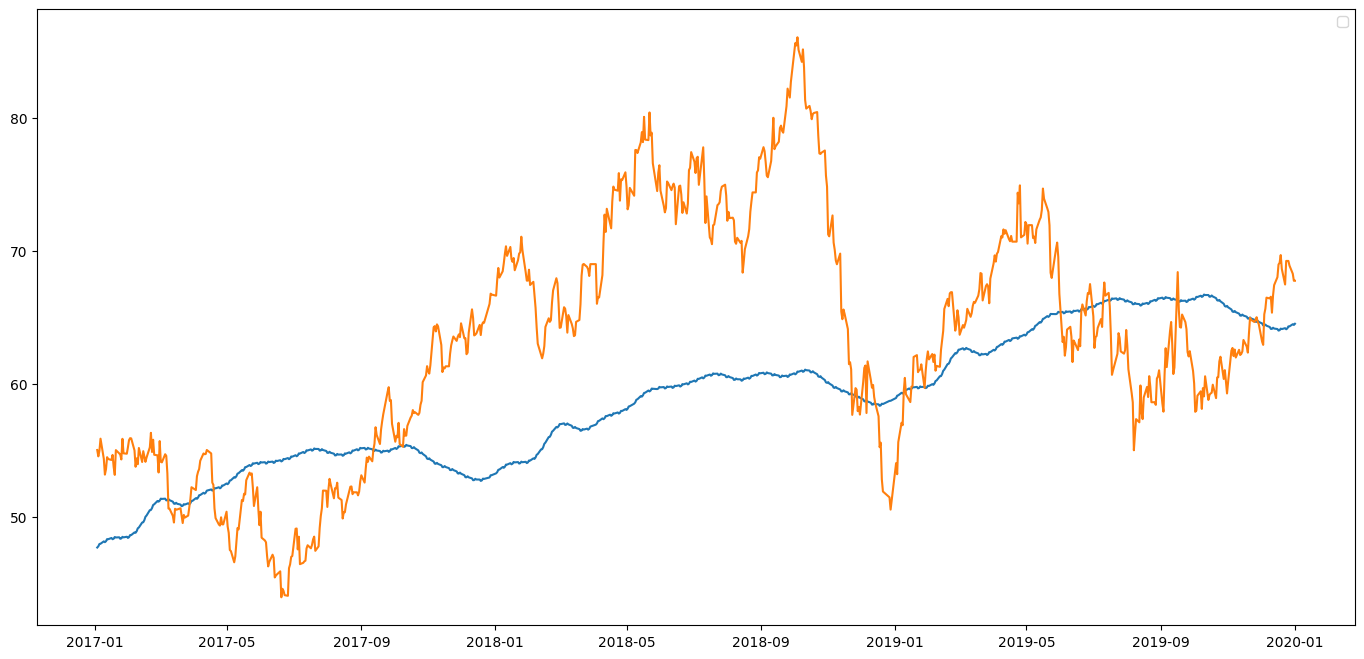

In [14]:
##Visulize how many months data was forecast with specific ranges.
def plot_price_forecast(df,start_date, end_date):
    cmp_df = df.loc[start_date:end_date]
    plt.figure(figsize=(17,8))
    plt.plot(cmp_df['yhat'])
    plt.plot(cmp_df['y'])
    plt.legend()
    plt.show()
plot_price_forecast(cmp_df,'2017-01-01','2020-01-01')


### 2) Using ARIMA Model

In [15]:
## First we import the required libraries
from statsmodels.tsa.arima_model import ARIMA    # ARIMA Modeling
from statsmodels.tsa.stattools import adfuller   # Augmented Dickey-Fuller Test for Checking Stationary
from statsmodels.tsa.stattools import acf, pacf  # Finding ARIMA parameters using Autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose # Decompose the ARIMA Forecast model

In [16]:
#Arima requires the date column to be set as index
arima_df = df.set_index('ds')
arima_df.head()


,y
ds,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [17]:
# plots the Rolling mean and standard deviation and then checks the stationarity of the time series using Augmented Dickey - Fuller Test
# Perform Augmented Dickey–Fuller test to check if the given Time series is stationary:
def test_stationarity(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


we use this function to check if our given timeseries data is stationary or not

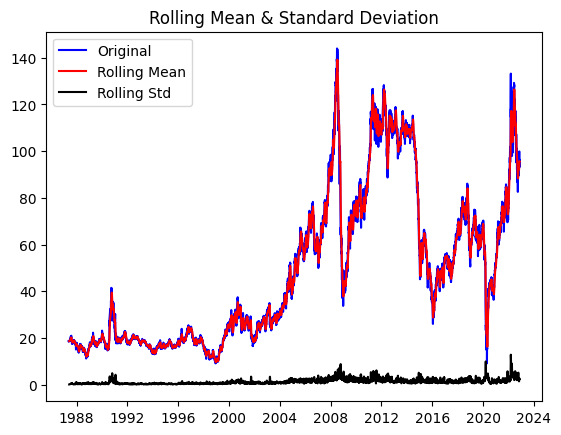

Results of Dickey-Fuller Test:
Test Statistic                   -1.993856
p-value                           0.289274
#Lags Used                       29.000000
Number of Observations Used    8981.000000
Critical Value (1%)              -3.431078
Critical Value (5%)              -2.861862
Critical Value (10%)             -2.566941
dtype: float64


In [18]:
test_stationarity(arima_df)

Observation - The null hypothesis of ADF test is the Time series is NOT stationary. We see that the Test Statistic (-1.95) is higher than 10% Critical Value (-2.56). This means this result is statistically significant at 90% confidence interval and so, we fail to reject the null hypothesis.

This means that our time series data is NOT stationary.

#### Find differnt Corelations

Correlation - Describes how much two variables depend on each other.

Partial Correlation - When multiple variables are involved, two variables may have direct relation as well as indirect relation (i.e x1 and x3 are related and x2 and x3 are related. Due to this indirect relation, x1 and x2 might be related). This is called partial correlation.

Auto Correlation - In a time series data, variable at a time step is dependent upon its lag values. This is called auto-correlation (i.e. variable depending upon its own values)

Partial Autocorrelation - describes correlation of a variable with its lag values after removing the effect of indirect correlation.



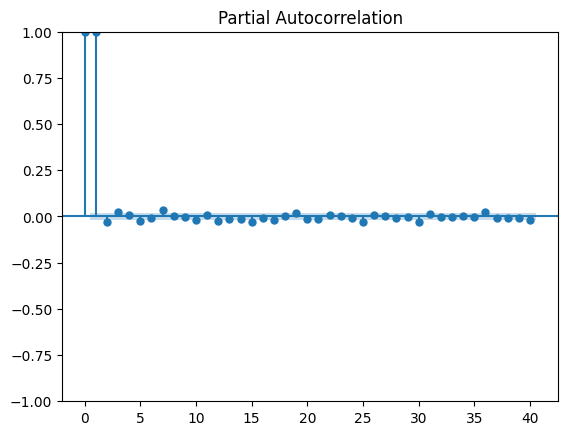

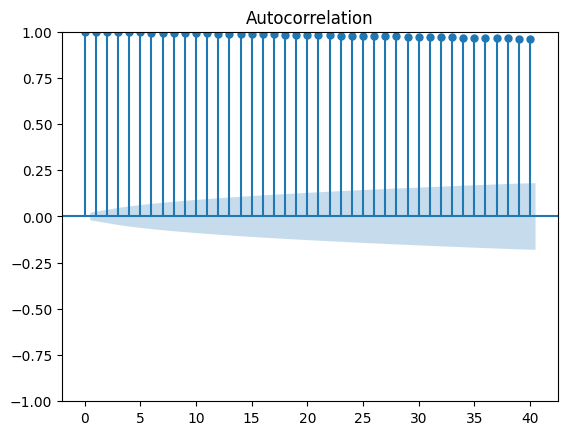

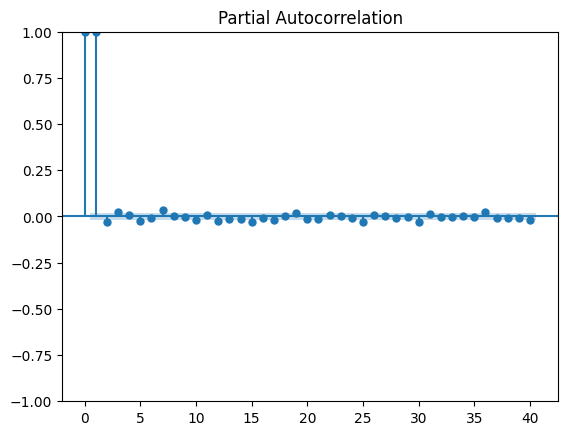

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(arima_df)
plot_pacf(arima_df)


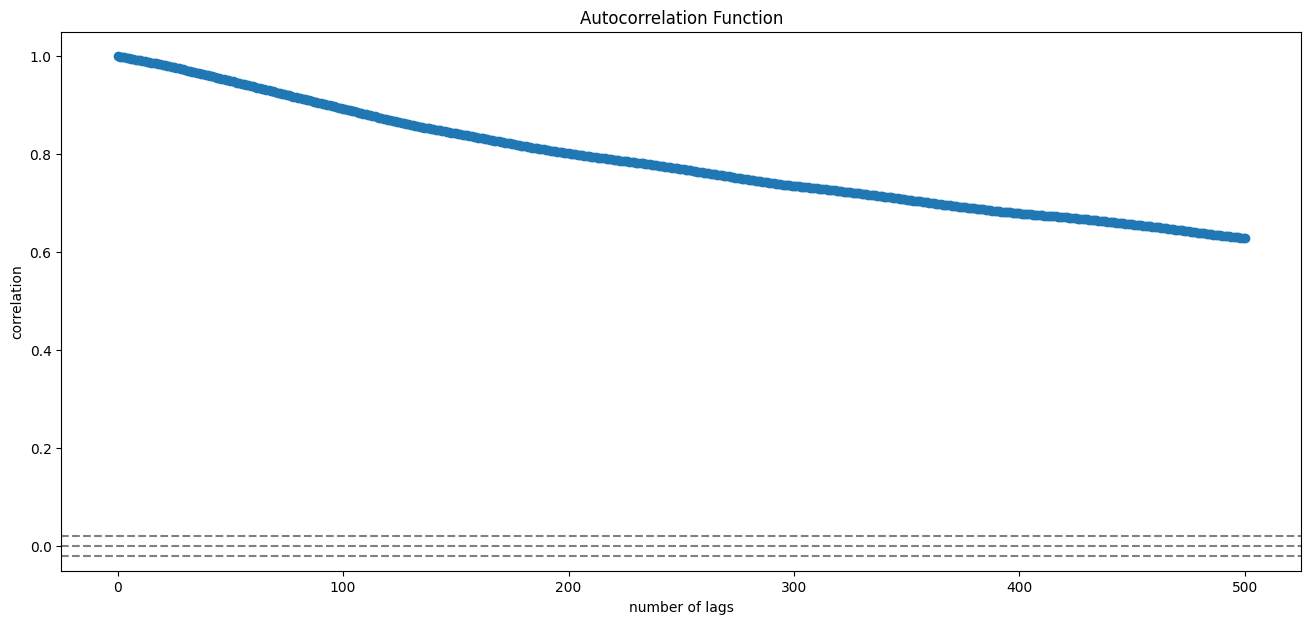

In [20]:
# Implementing own function to create ACF plot
def get_acf_plot(ts):
    #calling acf function from stattools
    y = ts['y']
    lag_acf = acf(y, nlags=500)
    plt.figure(figsize=(16, 7))
    plt.plot(lag_acf, marker="o")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
get_acf_plot(arima_df)
    

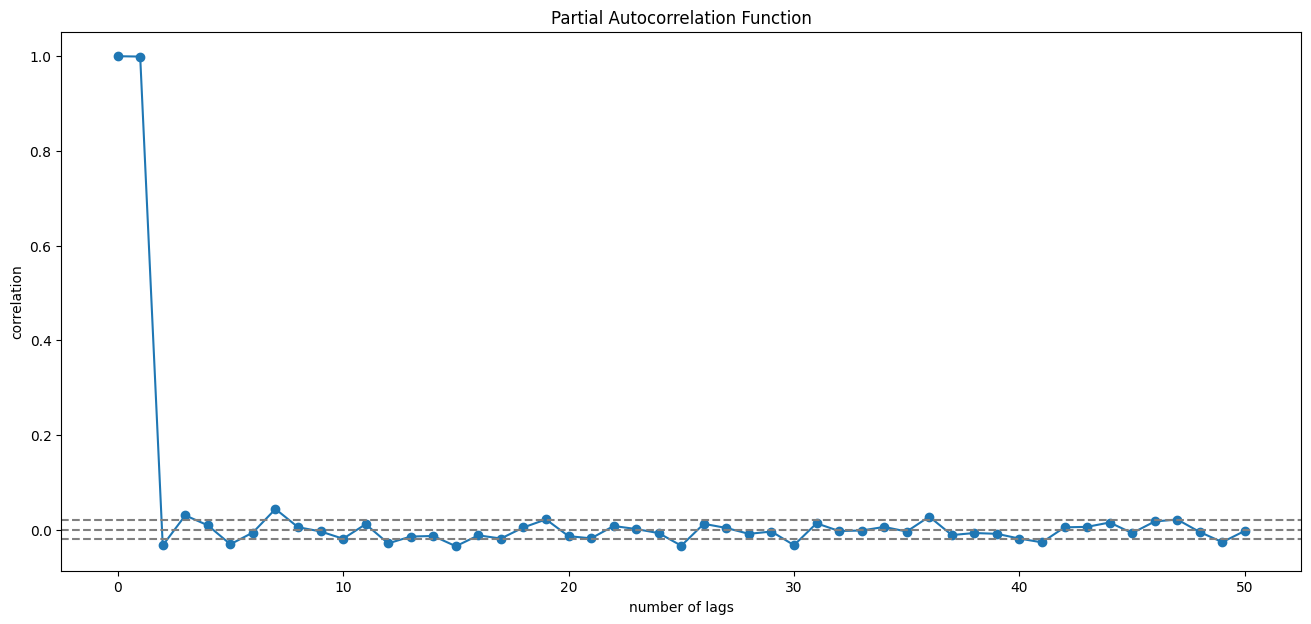

In [21]:

def get_pacf_plot(ts):
    #calling pacf function from stattools
    y = arima_df['y']
    lag_pacf = pacf(y, nlags=50)
    plt.figure(figsize=(16, 7))
    plt.plot(lag_pacf, marker="o")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
get_pacf_plot(arima_df)

Next we see some methods to make the data stationary

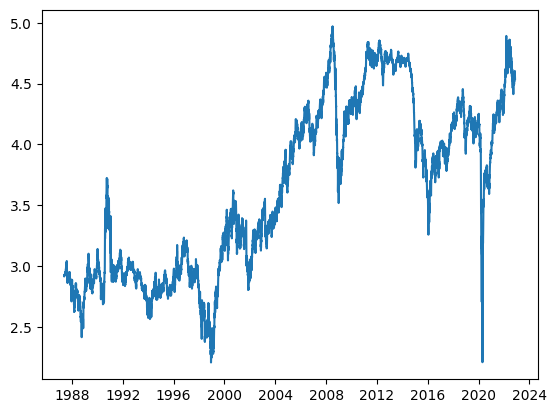

In [22]:
# Log Transformation
ts_log = np.log(arima_df)
plt.plot(ts_log)

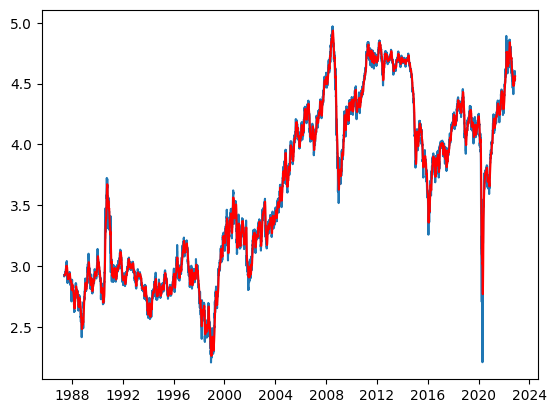

In [23]:
# Moving Average of last 12 values
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [24]:
# Differencing
ts_log_ma_diff = ts_log - moving_avg
ts_log_ma_diff.head(12)

,y
ds,
1987-05-20,NaN
1987-05-21,NaN
1987-05-22,NaN
1987-05-25,NaN
1987-05-26,NaN
1987-05-27,NaN
1987-05-28,NaN
1987-05-29,NaN
1987-06-01,NaN


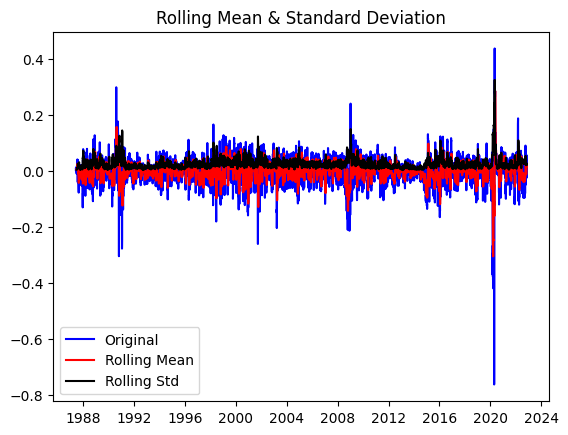

Results of Dickey-Fuller Test:
Test Statistic                -1.554817e+01
p-value                        2.116688e-28
#Lags Used                     2.900000e+01
Number of Observations Used    8.970000e+03
Critical Value (1%)           -3.431079e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566942e+00
dtype: float64


In [25]:
ts_log_ma_diff.dropna(inplace=True)
test_stationarity(ts_log_ma_diff)

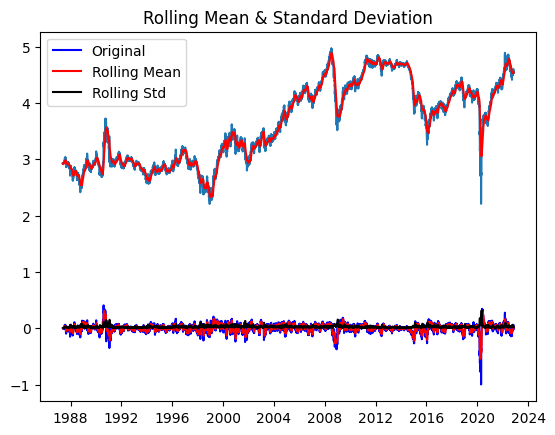

Results of Dickey-Fuller Test:
Test Statistic                -1.272776e+01
p-value                        9.519924e-24
#Lags Used                     2.900000e+01
Number of Observations Used    8.981000e+03
Critical Value (1%)           -3.431078e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566941e+00
dtype: float64


In [26]:
# Exponentially weighted moving average 
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

#### fit ARIMA models

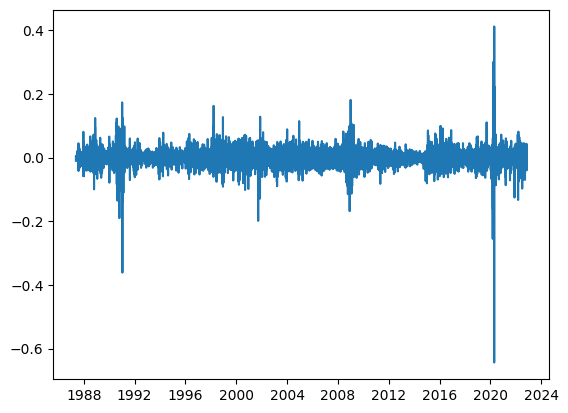

In [27]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

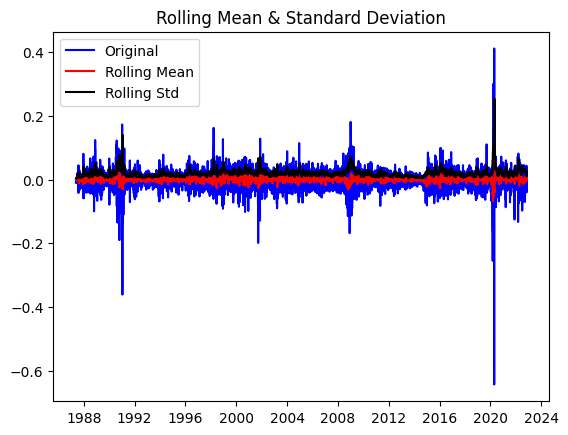

Results of Dickey-Fuller Test:
Test Statistic                -1.642711e+01
p-value                        2.498580e-29
#Lags Used                     2.800000e+01
Number of Observations Used    8.981000e+03
Critical Value (1%)           -3.431078e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566941e+00
dtype: float64


In [28]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

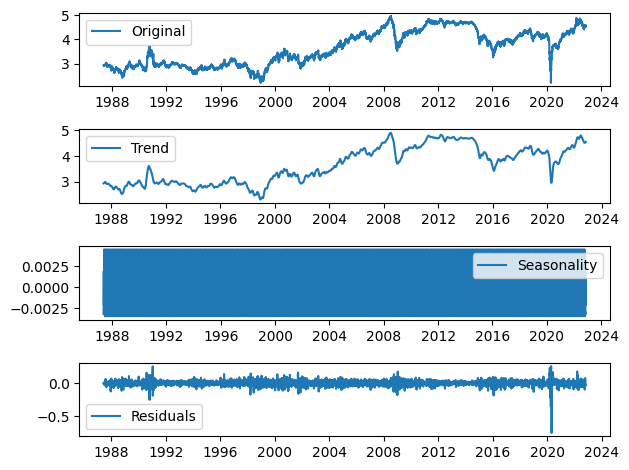

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, period=30)  # Use 'period' instead of 'freq'

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


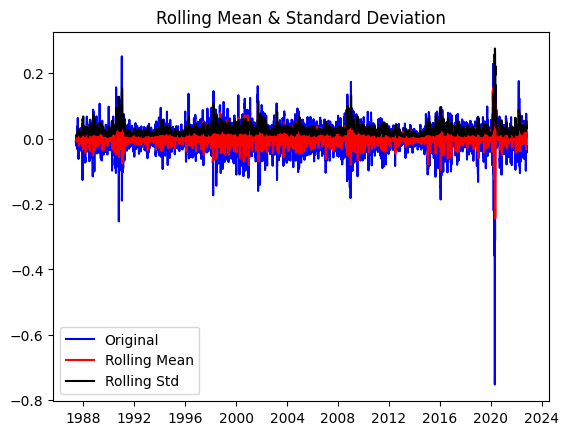

Results of Dickey-Fuller Test:


KeyError: 'y'

In [32]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)


In [33]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


3) Using LSTM

In [34]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df.Date = pd.to_datetime(df.Date)
df.head()


C:\Users\getac\AppData\Local\Temp\ipykernel_22216\2315330418.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.Date = pd.to_datetime(df.Date)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


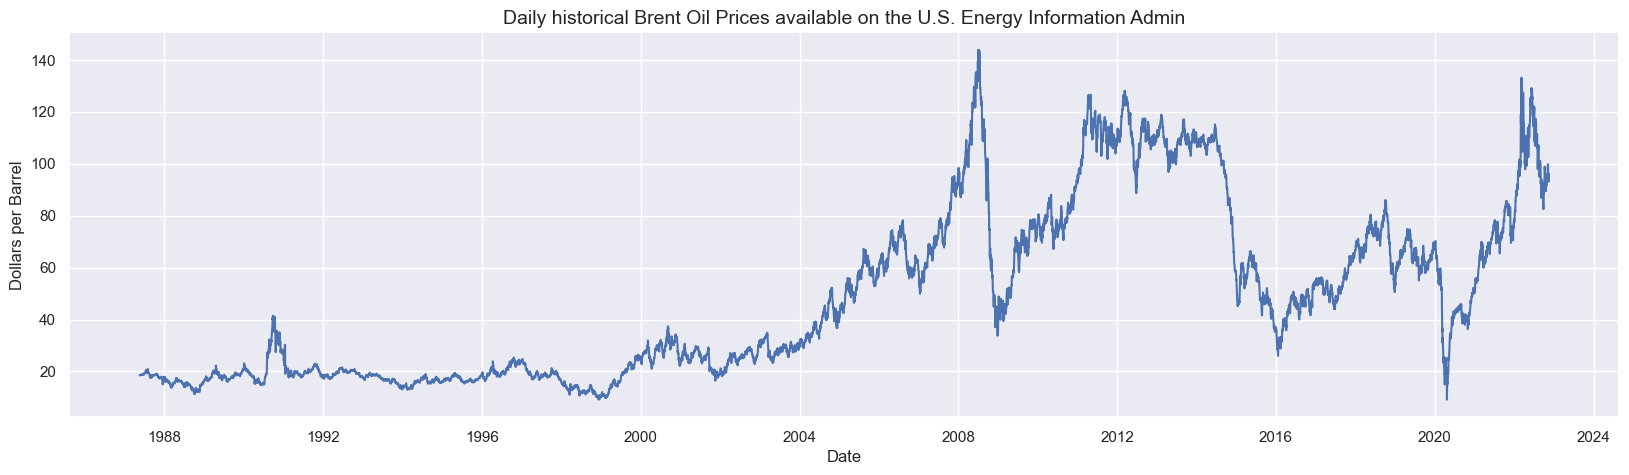

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns # using seaborn because the charts are more visually pleasing

sns.set(style="darkgrid")
plt.figure(figsize=(20,5))
sns.lineplot(x="Date", y="Price", data=df)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.show()

In [36]:
df.describe()

,Date,Price
count,9011,9011.000000
mean,2005-02-10 23:46:53.760958720,48.420782
min,1987-05-20 00:00:00,9.100000
25%,1996-03-20 12:00:00,19.050000
50%,2005-02-02 00:00:00,38.570000
75%,2014-01-09 12:00:00,70.090000
max,2022-11-14 00:00:00,143.950000
std,NaN,32.860110


In [37]:
scalerz = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scalerz.fit_transform(df.Price.values.reshape(-1, 1))

In [38]:
dataset[0:10]

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       [0.07044865],
       [0.07067112],
       [0.07044865],
       [0.07044865],
       [0.07030033],
       [0.07081943],
       [0.0710419 ]])

In [39]:
# split into train and test sets

splitz =0.7
train_size = int(len(dataset) * splitz)
test_size = int(len(dataset) * (1-splitz))
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 9011 >> Train length: 6307 || Test Length: 2704'

In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (6291, 15) || y_train: (6291,) || X_test: (2688, 15) || y_test: (2688,)'

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (6291, 1, 15) || y_train: (6291,) || X_test: (2688, 1, 15) || y_test: (2688,)'

In [43]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# Simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', 
# monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)


C:\Users\getac\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6291/6291 - 8s - 1ms/step - loss: 9.0071e-04
Epoch 2/20
6291/6291 - 7s - 1ms/step - loss: 2.3174e-04
Epoch 3/20
6291/6291 - 6s - 1ms/step - loss: 1.9649e-04
Epoch 4/20
6291/6291 - 6s - 999us/step - loss: 1.8075e-04
Epoch 5/20
6291/6291 - 6s - 999us/step - loss: 1.5442e-04
Epoch 6/20
6291/6291 - 6s - 993us/step - loss: 1.5503e-04
Epoch 7/20
6291/6291 - 6s - 906us/step - loss: 1.4211e-04
Epoch 8/20
6291/6291 - 7s - 1ms/step - loss: 1.4175e-04
Epoch 9/20
6291/6291 - 7s - 1ms/step - loss: 1.2613e-04
Epoch 10/20
6291/6291 - 6s - 966us/step - loss: 1.2753e-04
Epoch 11/20
6291/6291 - 6s - 917us/step - loss: 1.2542e-04
Epoch 12/20
6291/6291 - 6s - 954us/step - loss: 1.2821e-04
Epoch 13/20
6291/6291 - 7s - 1ms/step - loss: 1.2163e-04
Epoch 14/20
6291/6291 - 7s - 1ms/step - loss: 1.1954e-04
Epoch 15/20
6291/6291 - 6s - 924us/step - loss: 1.1779e-04
Epoch 16/20
6291/6291 - 6s - 900us/step - loss: 1.1412e-04
Epoch 17/20
6291/6291 - 6s - 904us/step - loss: 1.1772e-04
Epoch 18/20
6291/629

In [44]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# invert predictions
trainPredict = scalerz.inverse_transform(trainPredict)
trainY = scalerz.inverse_transform([y_train])
testPredict = scalerz.inverse_transform(testPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 1.22 RMSE
Test Score: 1.82 RMSE


In [45]:
# r2 scorez
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report


print('R2 Score: ', r2_score(testY[0], testPredict[:,0]))

R2 Score:  0.9950875482931811


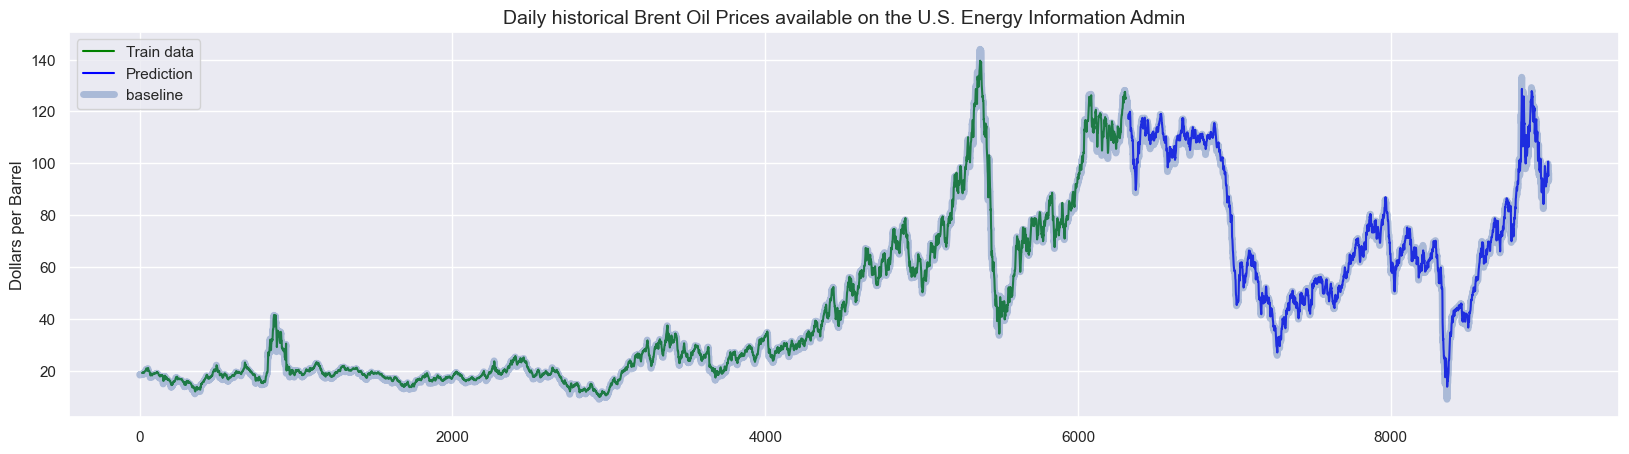

In [46]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()